<a href="https://colab.research.google.com/github/wish1421/BAIN/blob/main/Week_3_Programming_Probabilistically_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3: Programming Probabilistically

 Now that we have a very basic understanding of probability theory and Bayesian statistics, we are going
 to learn how to build probabilistic models using computational tools. Specifically, we are going to learn
 about probabilistic programming with PyMC.

 The basic idea is that we use code
 to specify statistical models and then PyMC will solve those models for us. We will not need to write
 Bayes’ theorem in explicit form. This is a good strategy for two reasons.

 * First, many models do not lead
 to an analytic closed form, and thus we can only solve those models using numerical techniques.

 * Second, modern Bayesian statistics is mainly done by writing code. We will be able to see that
 probabilistic programming offers an effective way to build and solve complex models and allows us to
 focus more on model design, evaluation, and interpretation, and less on mathematical or computational
 details.

In [ ]:
# Setting up the dependencies: (DO NOT EDIT THE LINES BELOW)
!pip install pymc==5.8.0 arviz==0.16.1 bambi==0.13.0 pymc-bart==0.5.2 kulprit==0.0.1 preliz==0.3.6 nutpie==0.9.1

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

In [ ]:
az.style.use("arviz-grayscale")
from cycler import cycler
default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc('axes', prop_cycle=default_cycler)
plt.rc('figure', dpi=300)

## 3.1 Probabilistic programming

Bayesian statistics is conceptually very simple. We have the **knowns** and the **unknowns**, and we use Bayes' theorem to condition the latter (unknowns) on the former (knowns). If we are lucky, this process will reduce the **uncertainty** about the **unknowns**. Generally, we refer to the *knowns as data and treat it like constants*, and *the unknowns as parameters and treat them as random variables.*

Even though the idea behind Bayesian statistics is straightforward, complex models involving probabilities can be difficult to solve with math. This was a big problem for a long time and limited how widely Bayesian methods were used. With computers and new calculation methods, things have changed dramatically. The arrival of the computational era and the
 development of numerical methods that, at least in principle, can be used to solve any inference problem,
have dramatically transformed the Bayesian data analysis practice. We can think of these numerical
 methods as **universal inference engines**.

 The possibility of automating the inference process has led to
 the development of **probabilistic programming languages (PPLs)**, which a lows a clear separation
 between model creation and inference. In the PPL framework, users specify a full probabilistic model
 by writing a few lines of code, and then inference folows automatica ly.

# 3.1.1 Flipping coins the PyMC way

*You should be familiar with Week 2 Coin Flipping Problem to proceed with this. Goes without saying.*

 Let's revisit the coin-flipping problem from Week 2, but this time using PyMC. We will use the same synthetic data we used in that chapter. Since we are generating the data, we know the true value of θ,
 called `theta_real`, in the folowing block of code. Of course, for a real dataset, we wil not have this
 knowledge:


In [ ]:
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = pz.Binomial(n = 1, p = theta_real).rvs(trials)
data

array([1, 0, 0, 0])

 Now that we have the data, we need to specify the model. Remember that this is done by specifying the
 likelihood and the prior.

 For the likelihood, we will use the Binomial distribution with parameters n = 1, p = θ, and for the prior, a Beta distribution with the parameters α = β = 1. A Beta distribution with such
 parameters is equivalent to a Uniform distribution on the interval [0, 1].

 Using mathematical notation we
 can write the model as:
 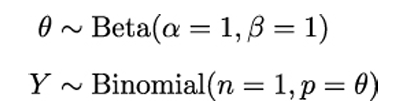

 This statistical model has an almost one-to-one translation to PyMC:

In [ ]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data)
    idata = pm.sample(1000, random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


The first line of the code creates a container for our model. Everything inside the with block will be automatically added to `our_first_model`. You can think of this as syntactic sugar to ease model specification as we do not need to manually assign variables to the model.

The second line specifies the prior. As you can see, the syntax follows the mathematical notation closely. The third line specifies the likelihood; the syntax is almost the same as for the prior, except that we pass the data using the `observed` argument. The observed values can be passed as a Python list, a tuple, a NumPy array, or a pandas DataFrame. With that, we are finished with the model specification! Pretty neat, right?

We have one more line of code to explain. This last line is where the important stuff happens. It may look simple, but PyMC is doing a lot of work behind the scenes. For now, we'll think of this line as a "black box" that gives us the correct result. What you need to know is that PyMC uses numerical methods to compute the posterior distribution. These methods can solve any model we create, but the result will be in the form of samples from the posterior distribution.

Later, we'll see that these samples match a Beta distribution, as we discussed earlier. Because these methods are random, the samples will be different each time we run the code. However, if everything works correctly, the samples will accurately represent the posterior distribution, and we'll get the same conclusions from any set of samples.

 The details of what happens under the hood and how to check if the samples are indeed trustworthy wil be explained later in the project.


One more thing: the `idata` variable is an `InferenceData` object, which is a container for all the data generated by PyMC. We wil learn more about this today.

OK, so on the last line, we are asking for 1,000 samples from the posterior. If you run the code, you will
 get a message like this:
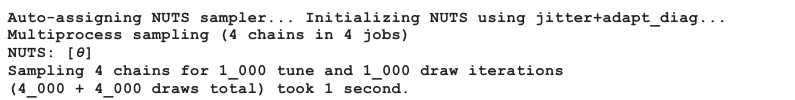


The first and second lines tell us that PyMC has automatically assigned the NUTS sampler (an inference engine that works very well for continuous variables) and has used a method to initialize that sampler (these methods need an initial guess of where to start sampling). The third line says that PyMC will run four chains in parallel, so we will get four independent samples from the posterior. As PyMC attempts to parallelize these chains across the available processors in your machine, we will get four for the price of one.

The exact number of chains is computed based on the number of processors in your machine; you can change it using the `chains` argument for the `sample` function. The next line tells us which variables are being sampled by which sampler. In this particular case, this line is not adding new information because NUTS is used to sample the only variable we have, θ. However, this is not always the case, as PyMC can assign different samplers to different variables. PyMC has rules to ensure that each variable is associated with the best possible sampler. Users can manually assign samplers using the `step` argument of the `sample` function, but you will rarely need to do that.

Finally, the last line is a progress bar with several related metrics showing how fast the sampler is working, including the number of iterations per second. If you run the code, you'll see the progress bar update very quickly. Here, we are seeing the final stage when the sampler has finished its work.

You'll notice that we asked for 1,000 samples, but PyMC is computing 8,000 samples. We have 1,000 draws per chain to tune the sampling algorithm (NUTS, in this example). These tuning draws are discarded by default; PyMC uses them to increase the efficiency and reliability of the sampling method, which are both important for obtaining a useful approximation of the posterior. We also have 1,000 productive draws per chain, totaling 4,000. These are the ones we will use as our posterior samples. We can change the number of tuning steps with the `tune` argument of the `sample` function and the number of draws with the `draws` argument.

### 3.1.2 Summarizing the posterior

 Generally, the first task we will perform after sampling from the posterior is to check what the results
 look like. The `plot_trace` function from ArviZ is ideally suited to this task:


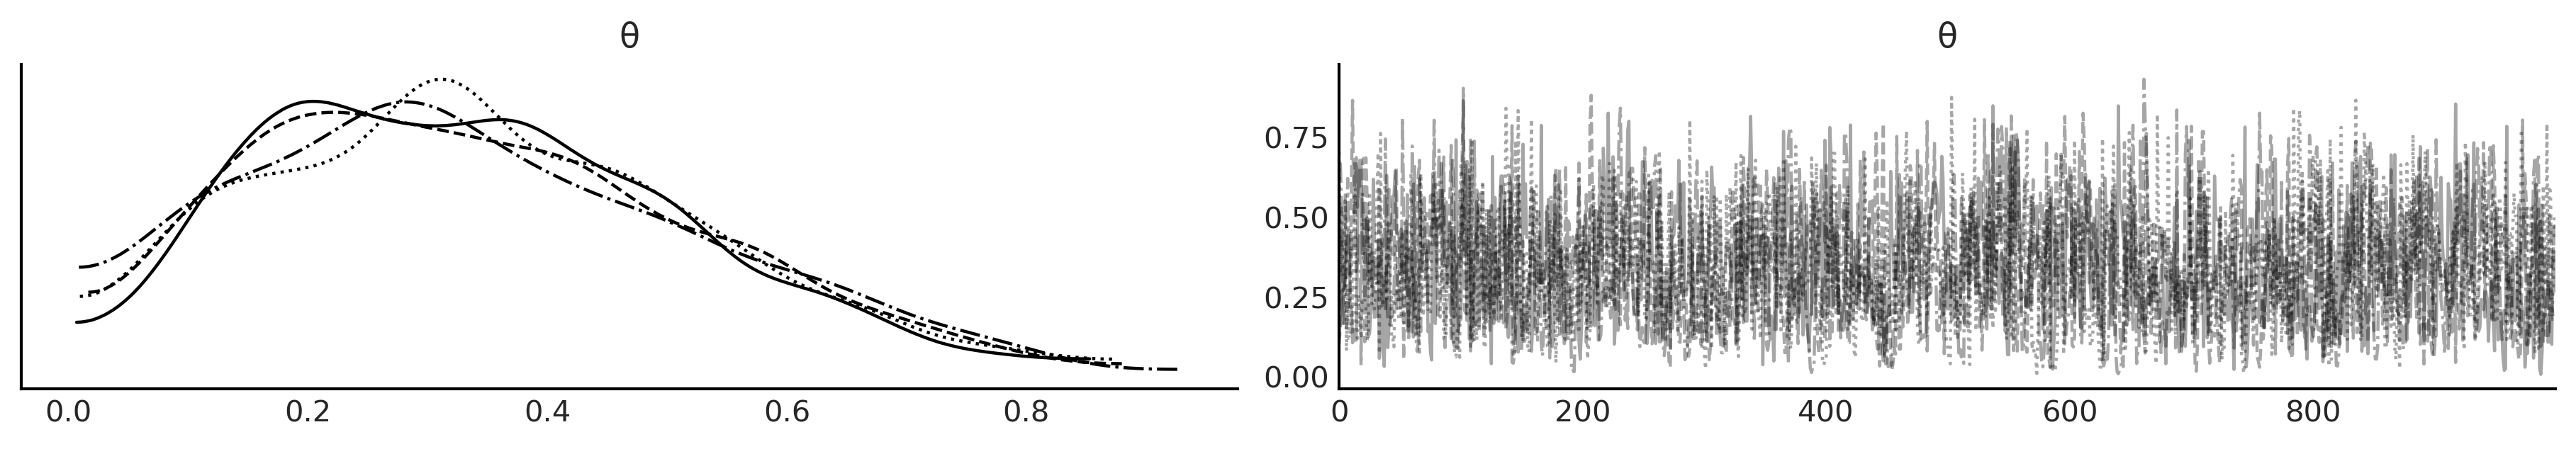

In [ ]:
az.plot_trace(idata)
# plt.savefig("../fig/idata_trace.png")

Above figure shows the default result when calling `az.plot_trace`; we get two subplots for each unobserved variable. The only unobserved variable in our model is θ. Notice that y is an observed variable representing the data; we do not need to sample that because we already know those values.

Thus we only get two subplots. On the left, we have a Kernel Density Estimation (KDE) plot; this is like the smooth version of the histogram.

Ideally, we want all chains to have a very similar KDE. On the right, we get the individual values at each sampling step; we get as many lines as
 chains. Ideally, we want it to be something that looks noisy, with no clear pattern, and we should have a hard time identifying one chain from the others.

We will give more details on how to
 interpret these plots. The gist is that if we ran many chains, we would expect them to be practically
 indistinguishable from each other. The sampler did a good job and we can trust the samples.

As with other ArviZ functions, `az.plot_trace` has many options. For instance, we can run this function with the `combined` argument set to `True` to get a single KDE plot for all chains, and with `kind='rank_bars'` to get a rank plot.

Below is a trace plot for the posterior of `our_first_model`, using the options `kind="rank_bars",combined=True`

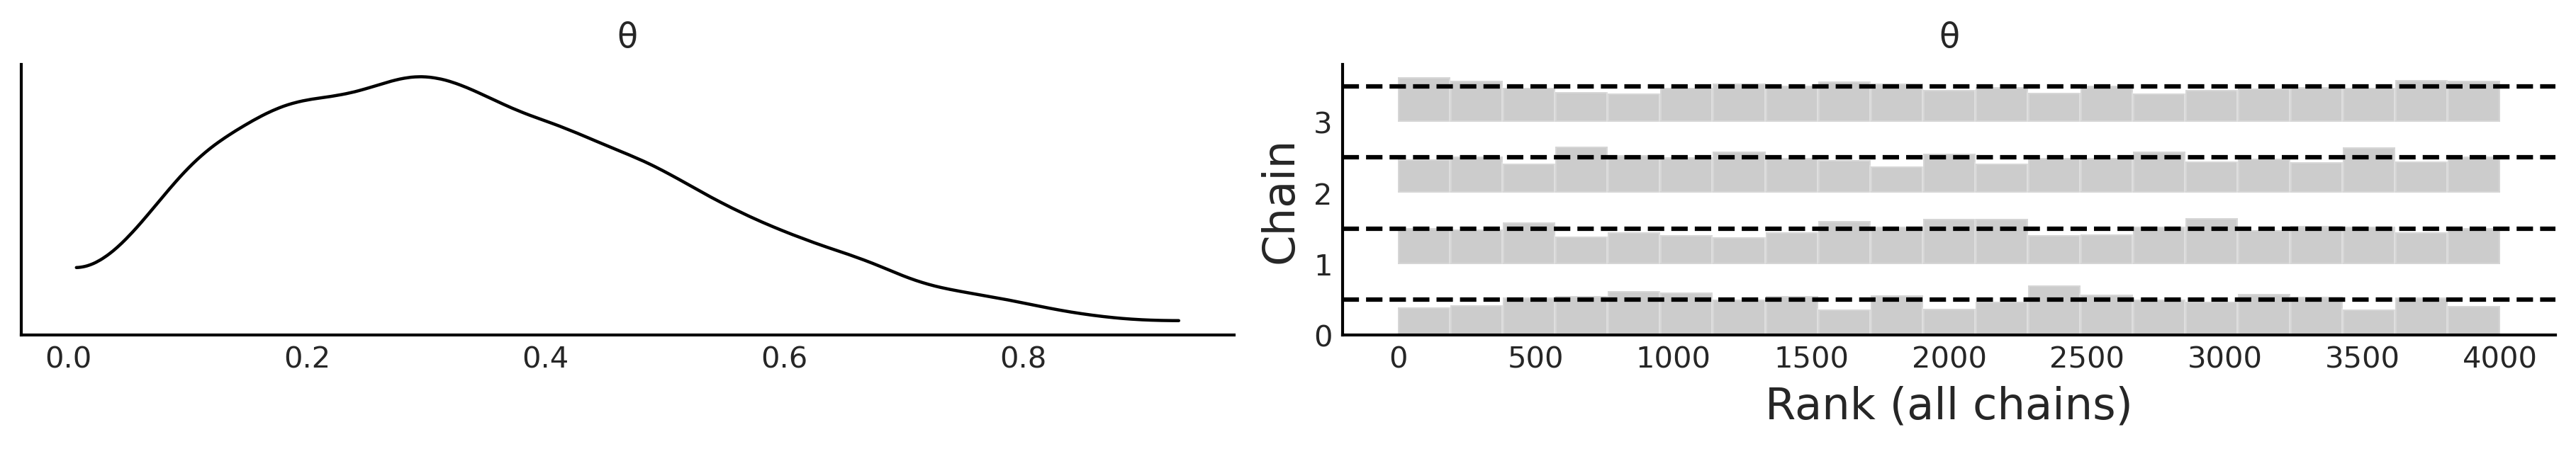

In [ ]:
az.plot_trace(idata, kind="rank_bars", combined=True, rank_kwargs={"colors": "k"});
# plt.savefig("../fig/idata_rank.png")

A rank plot is another way to check if we can trust the samples. For this plot, we get one histogram per chain, and we want all of them to be as uniform as possible, like in above figure. Some small deviations from uniformity are expected due to random sampling, but large deviations indicate that chains are exploring different regions of the posterior. Ideally, we want all chains to explore the entire posterior. Later, we provide further details on how to interpret rank plots and how they are constructed.

ArviZ provides several other plots to help interpret the posterior, and we wil see them in the folowing
 pages. We may also want to have a numerical summary of the posterior. We can get that using
 `az.summary`, which wil return a pandas DataFrame as shown

In [ ]:
az.summary(idata, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
θ,0.34,0.18,0.04,0.67


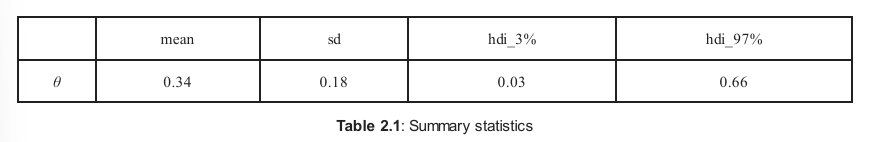

In the first column, we have the name of the variable. The second column shows the mean of the posterior distribution, the third column gives the standard deviation, and the last two columns provide the lower and upper boundaries of the 94% highest density interval (HDI). According to our model and data, we estimate that the value of θ is likely to be around 0.34, with a 94% probability that it is actually between 0.03 and 0.66.

We can also summarize using the standard deviation. The advantage of using the standard deviation is that it is a more commonly used statistic. However, we need to be cautious when interpreting it to avoid misleading conclusions. For example, if we calculate the mean ± 2 standard deviations, we get the interval (-0.02, 0.7). While the upper value is close to 0.66 (from the HDI), the lower bound is outside the possible range for θ, which is between 0 and 1.

Another way to visually summarize the posterior is to use the `az.plot_posterior` function in ArviZ (see below). We used this function in the previous week for a fake posterior. Now, we will use it for a real posterior.

```python
az.plot_posterior(idata)
```

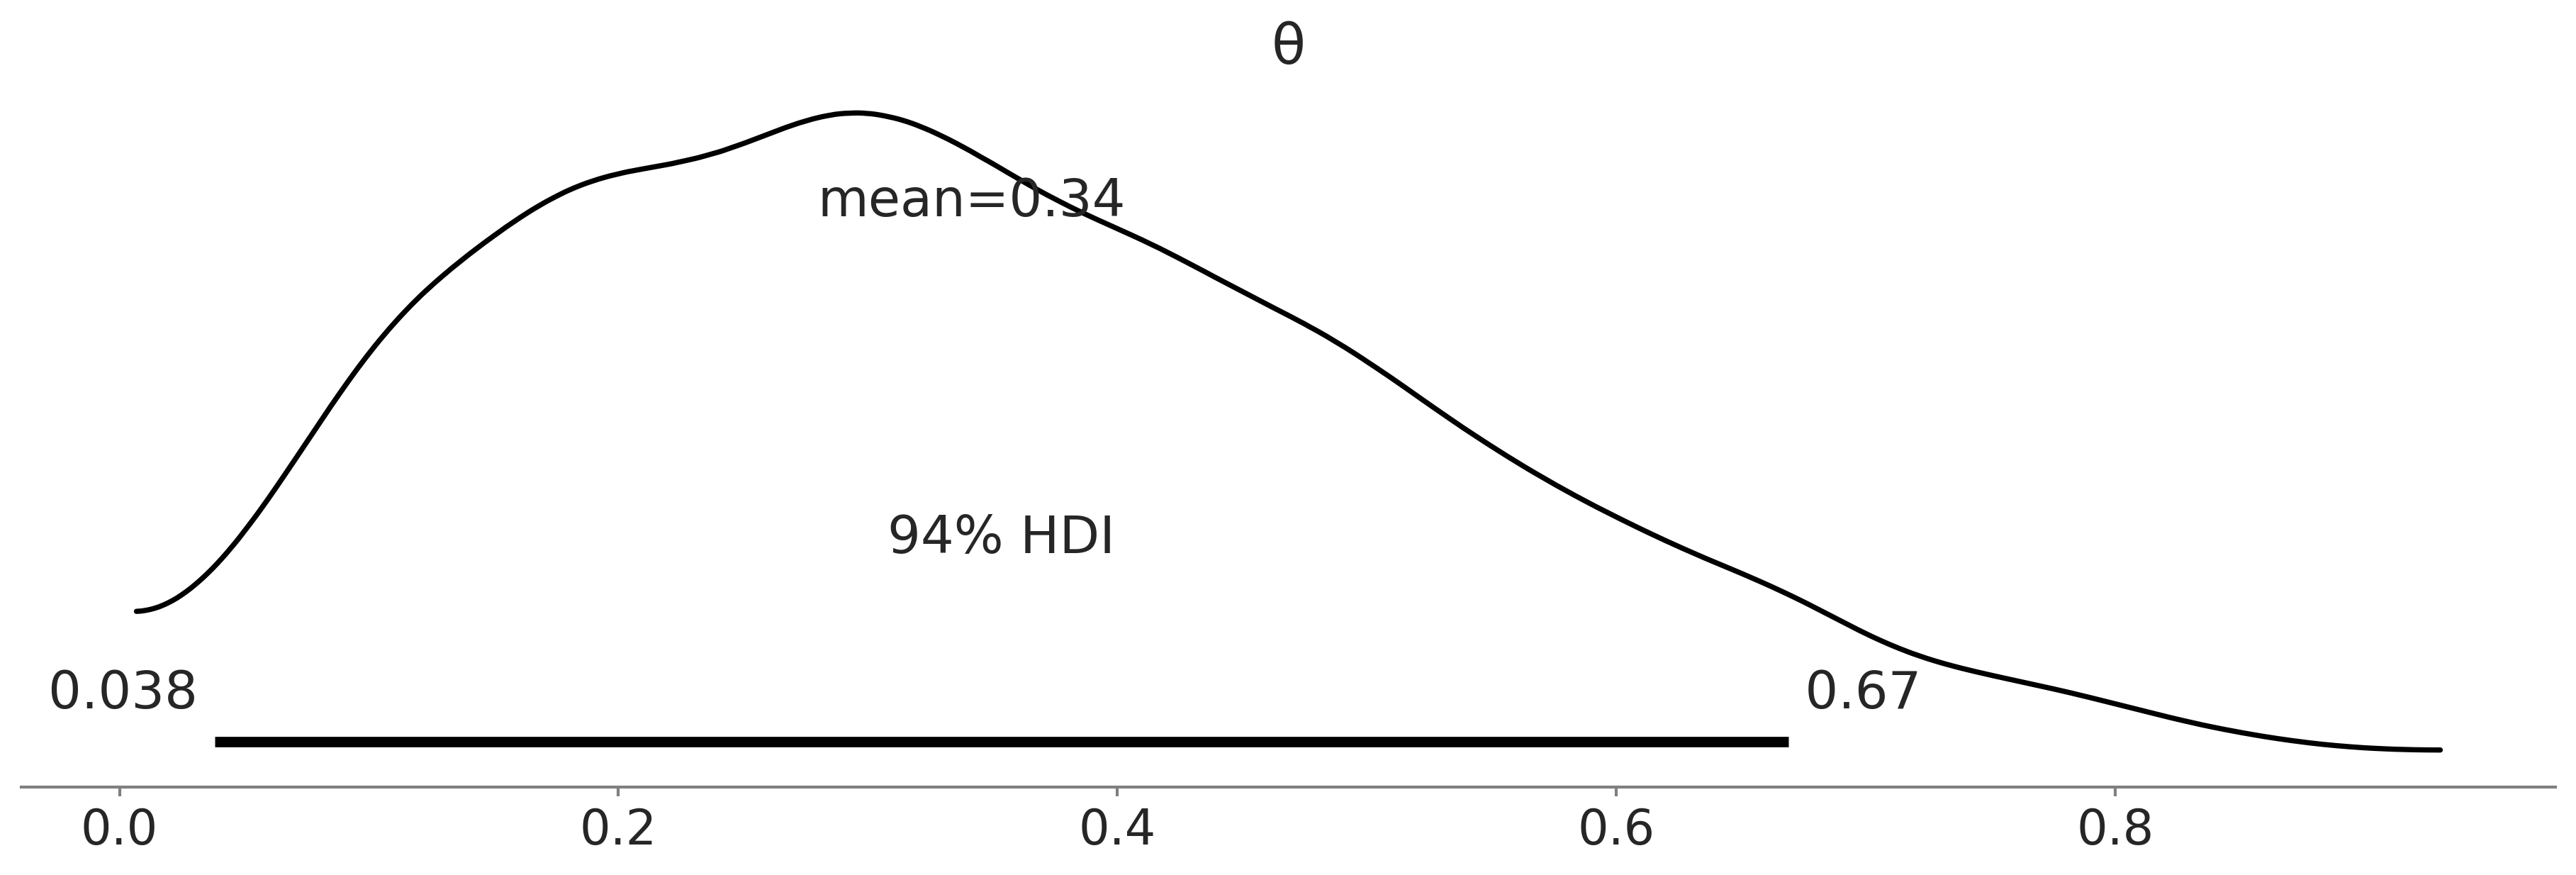

In [ ]:
az.plot_posterior(idata, figsize=(12, 4))
# plt.savefig("../fig/idata_posterior.png")

Figure shows the posterior distribution of θ and the 94% HDI.

By default, `plot_posterior` displays a histogram for discrete variables and KDEs for continuous variables. It also shows the mean of the distribution (we can request the median or mode using the `point_estimate` argument) and the 94% HDI as a black line at the bottom of the plot. You can set different interval values for the HDI with the `hdi_prob` argument.

###  3.1.3 Posterior-based decisions

Sometimes, describing the posterior is not enough. We may need to make decisions based on our inferences and reduce a continuous estimation to a dichotomous one: yes-no, healthy-sick, contaminated-safe, and so on. For instance, is the coin fair? A fair coin has a θ value of exactly 0.5. We can compare this value against the HDI interval. From last figure, we see that the HDI ranges from 0.03 to 0.7, so 0.5 is included in the HDI. This suggests that the coin may be biased toward tails, but we cannot completely rule out the possibility that the coin is actually fair. If we want a more definitive answer, we will need to collect more data to reduce the spread of the posterior, or we might need to define a more informative prior.

**Savage-Dickey density ratio**

One way to evaluate how much support the posterior provides for a given value is to compare the ratio
 of the posterior and prior densities at that value. This is ca led the Savage-Dickey density ratio and we
 can compute it with ArviZ using the `az.plot_bf` function:

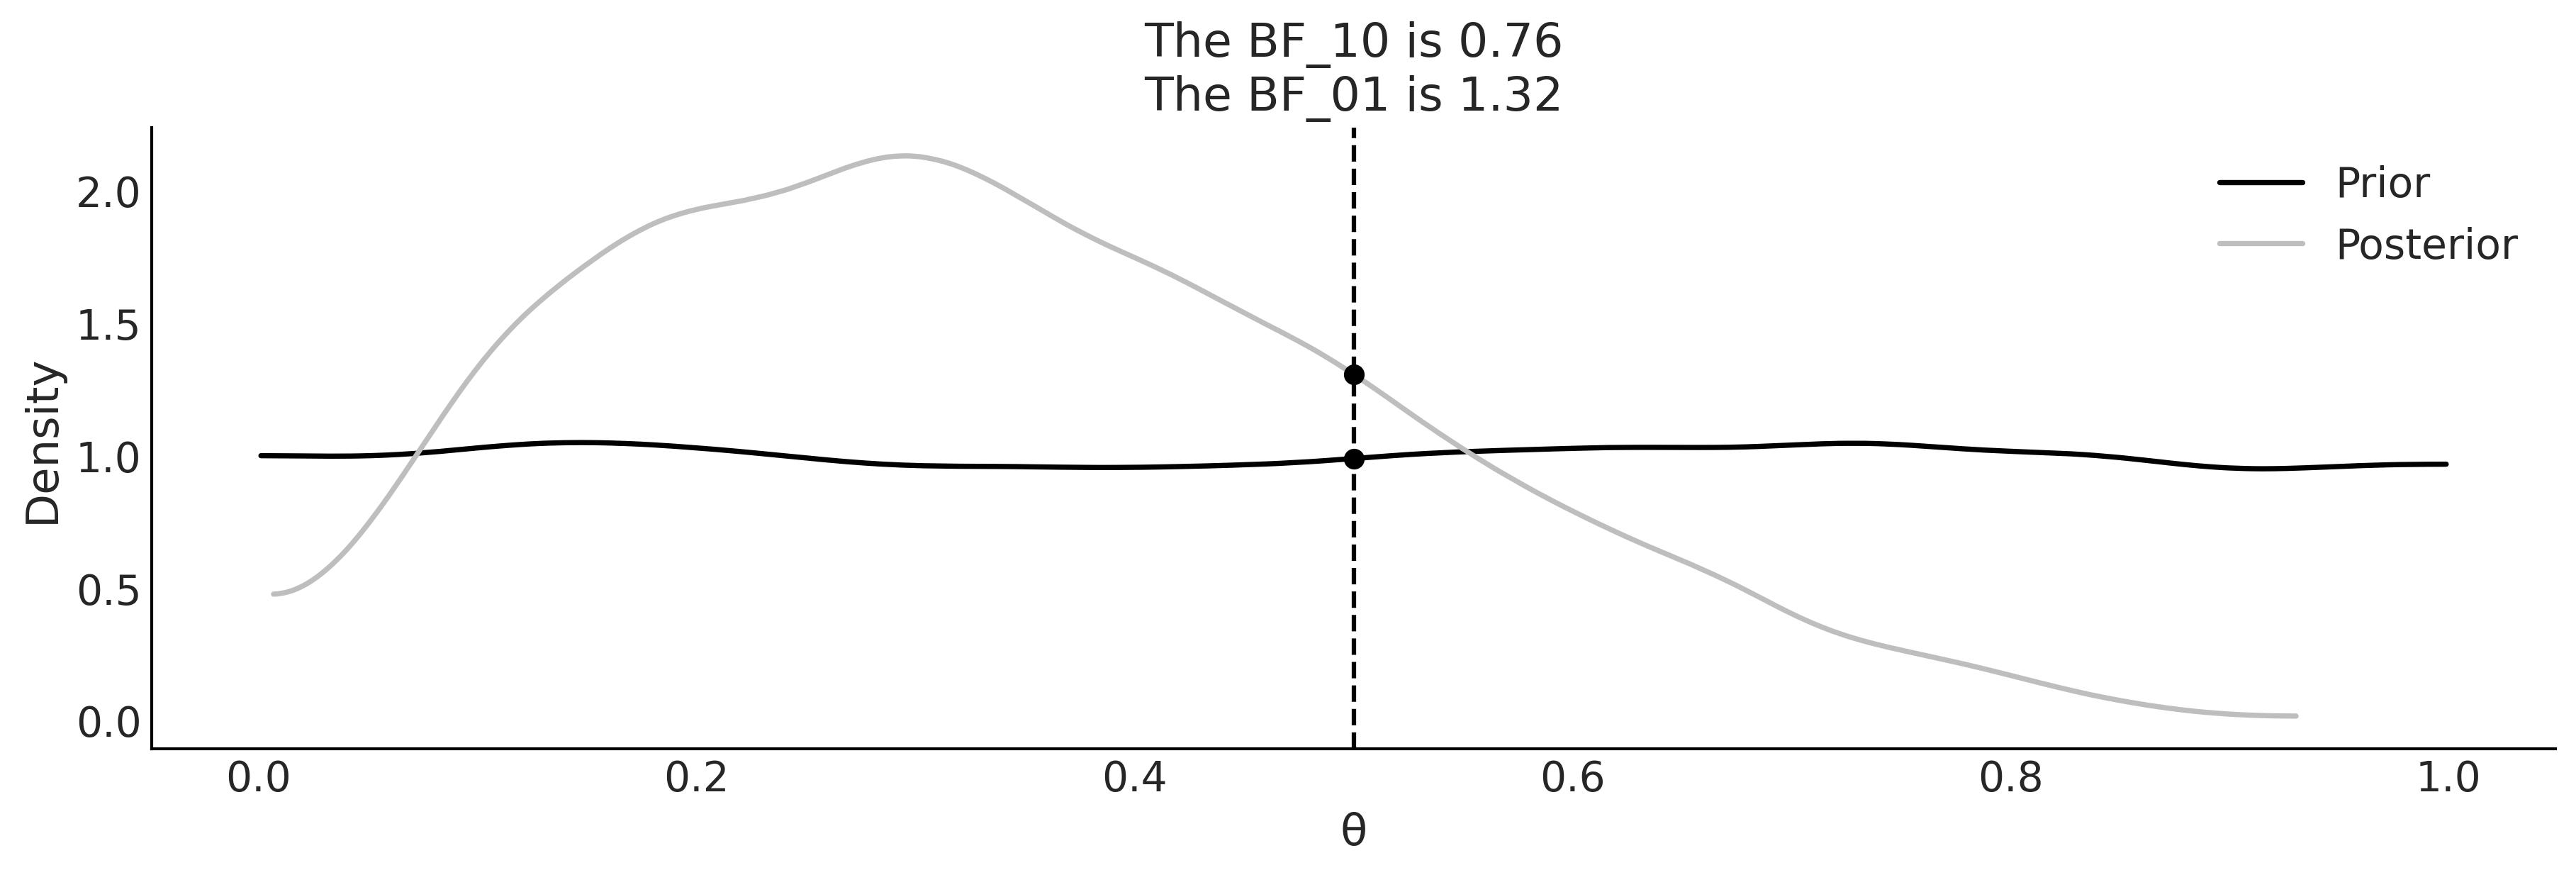

In [ ]:
az.plot_bf(idata, var_name="θ", prior=np.random.uniform(0, 1, 10000), ref_val=0.5, figsize=(12, 4), colors=["C0", "C2"])
# plt.savefig("../fig/idata_bf.png")

We can see that the value of BF_01 is 1.3, which means that the value of θ = 0.5 is 1.3 times more likely under the posterior distribution than under the prior distribution. To compute this value, we simply divided the height of the posterior at θ = 0.5 by the height of the prior at θ = 0.5. The value of BF_10 is just the inverse, approximately 0.8. This means that θ ≠ 0.5 is 0.8 times more likely under the posterior than under the prior. How do we interpret these numbers? With a pinch of salt. The following table shows one possible interpretation originally proposed by Raftery (1995):
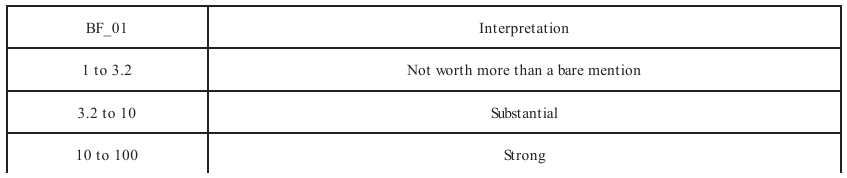
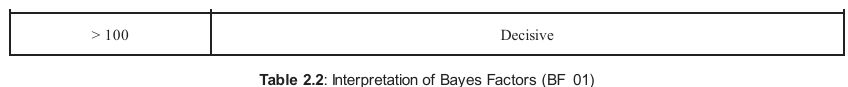


The Savage-Dickey density ratio is a particular way to compute what is called the Bayes Factor. We
 wil learn more about Bayes Factors later.

### Region Of Practical Equivalence (ROPE)

Strictly speaking, the chance of observing exactly 0.5 (with infinite trailing zeros) is zero. In practice, we generally do not care about exact results but rather results within a certain margin. Therefore, we can relax the definition of fairness and say that a fair coin is one with a value around 0.5. For example, we might say any value in the interval [0.45, 0.55] is practically equivalent to 0.5. This interval is called the Region Of Practical Equivalence (ROPE).

Once the ROPE is defined, we compare it with the HDI. We can get at least three scenarios:

1. The ROPE does not overlap with the HDI; we can say the coin is not fair.
2. The ROPE contains the entire HDI; we can say the coin is fair.
3. The ROPE partially overlaps with the HDI; we cannot definitively say whether the coin is fair or unfair.

If we choose the ROPE to match the entire range of a parameter, like [0, 1] for the coin-flipping example, we will always conclude that the coin is fair. Notice that in this case, we do not need to collect data to perform any type of inference.

The choice of ROPE is completely arbitrary: we can choose any value we want. Some choices are not very useful. For example, if we choose the ROPE to be [0, 1] for the coin-flipping example, we will always say the coin is fair, without needing to collect data or perform any analysis. This is a trivial example. More worrisome is picking the ROPE after performing the analysis, as this can lead to biased conclusions that match our expectations. Therefore, the ROPE should be informed by domain knowledge.

We can use the `plot_posterior` function to plot the posterior with the HDI interval and the ROPE. The ROPE appears as a semi-transparent thick gray line.

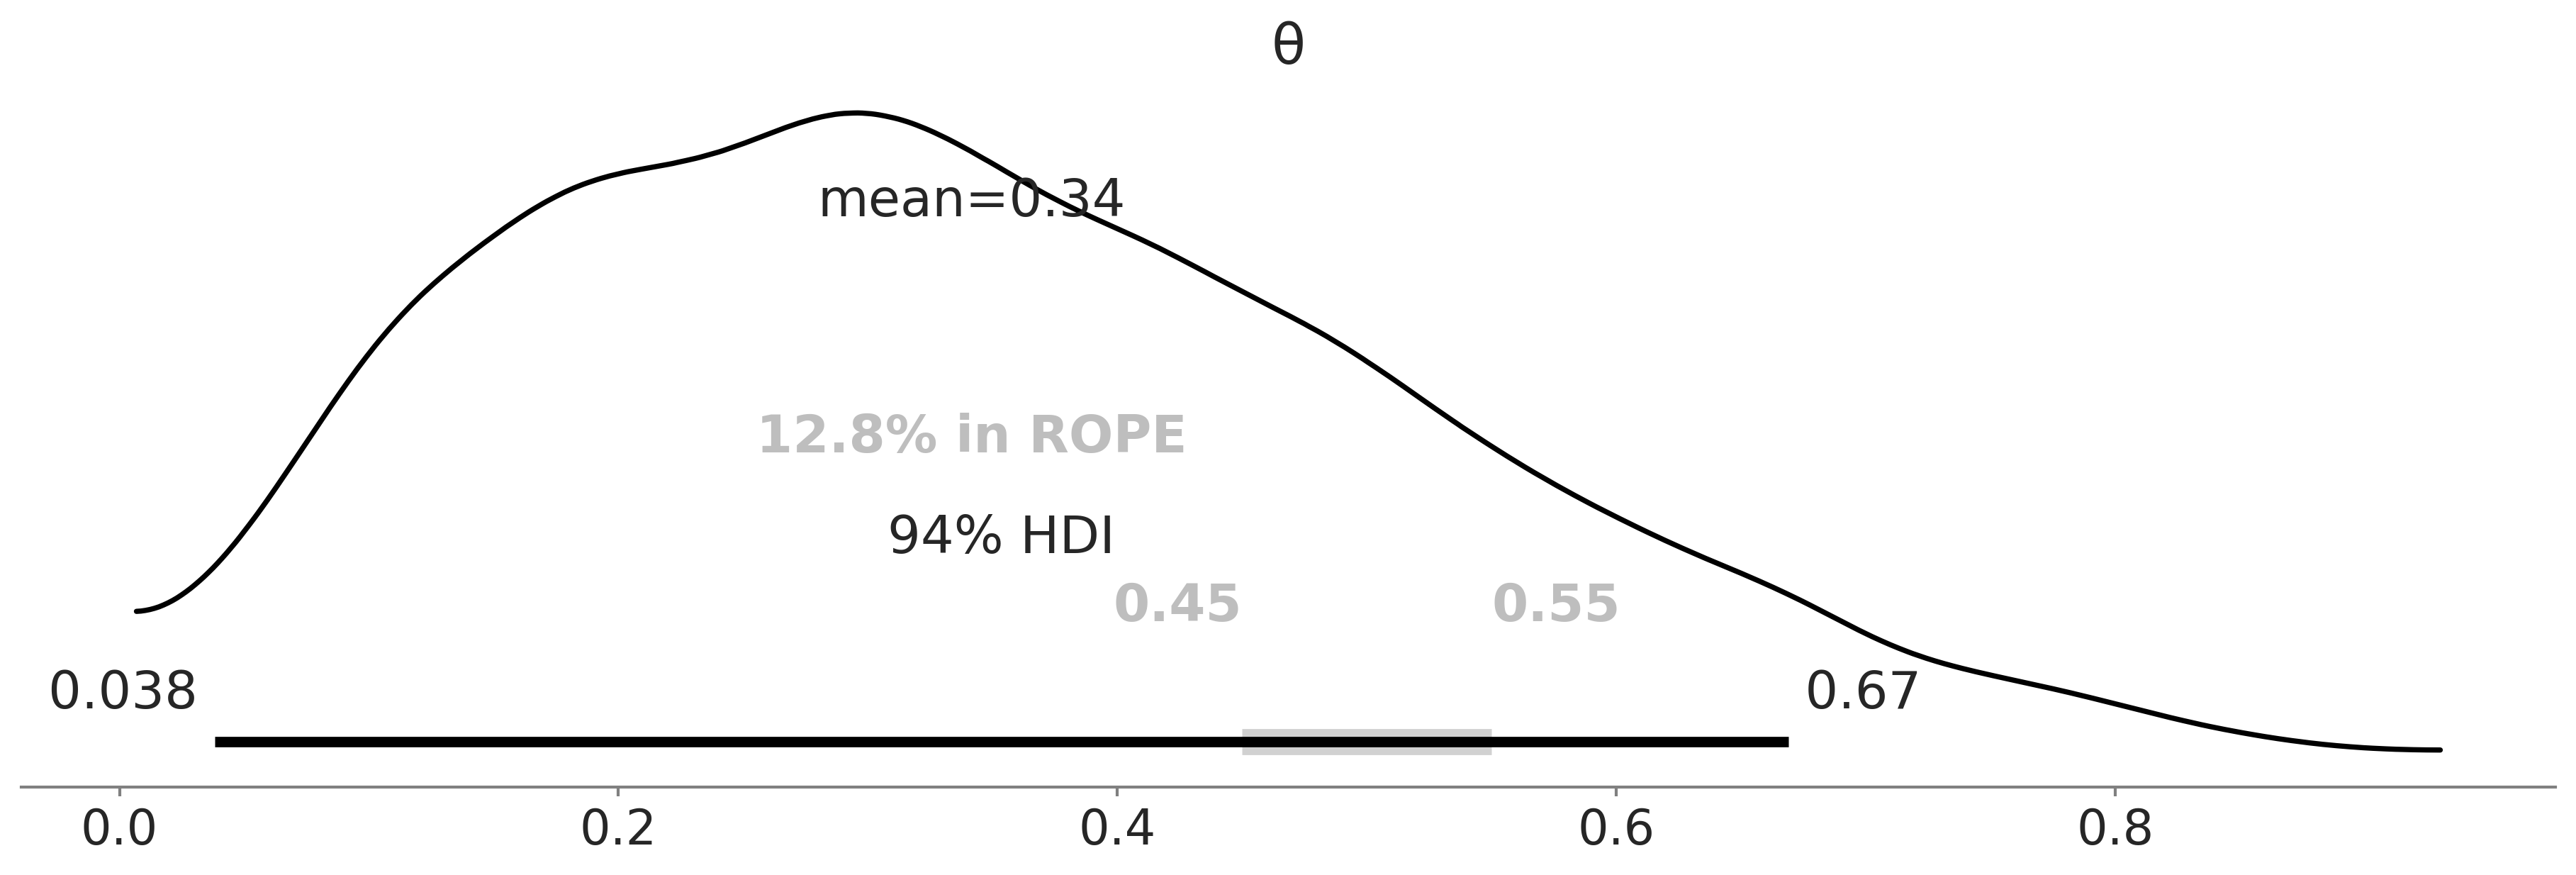

In [ ]:
az.plot_posterior(idata, rope=[0.45, .55], figsize=(12, 4))
# plt.savefig("../fig/idata_posterior_rope.png")


Another tool we can use to help us make a decision is to compare the posterior against a reference
 value. We can do this using plot_posterior. As you can see below, we get a vertical (gray)
 line and the proportion of the posterior above and below our reference value:

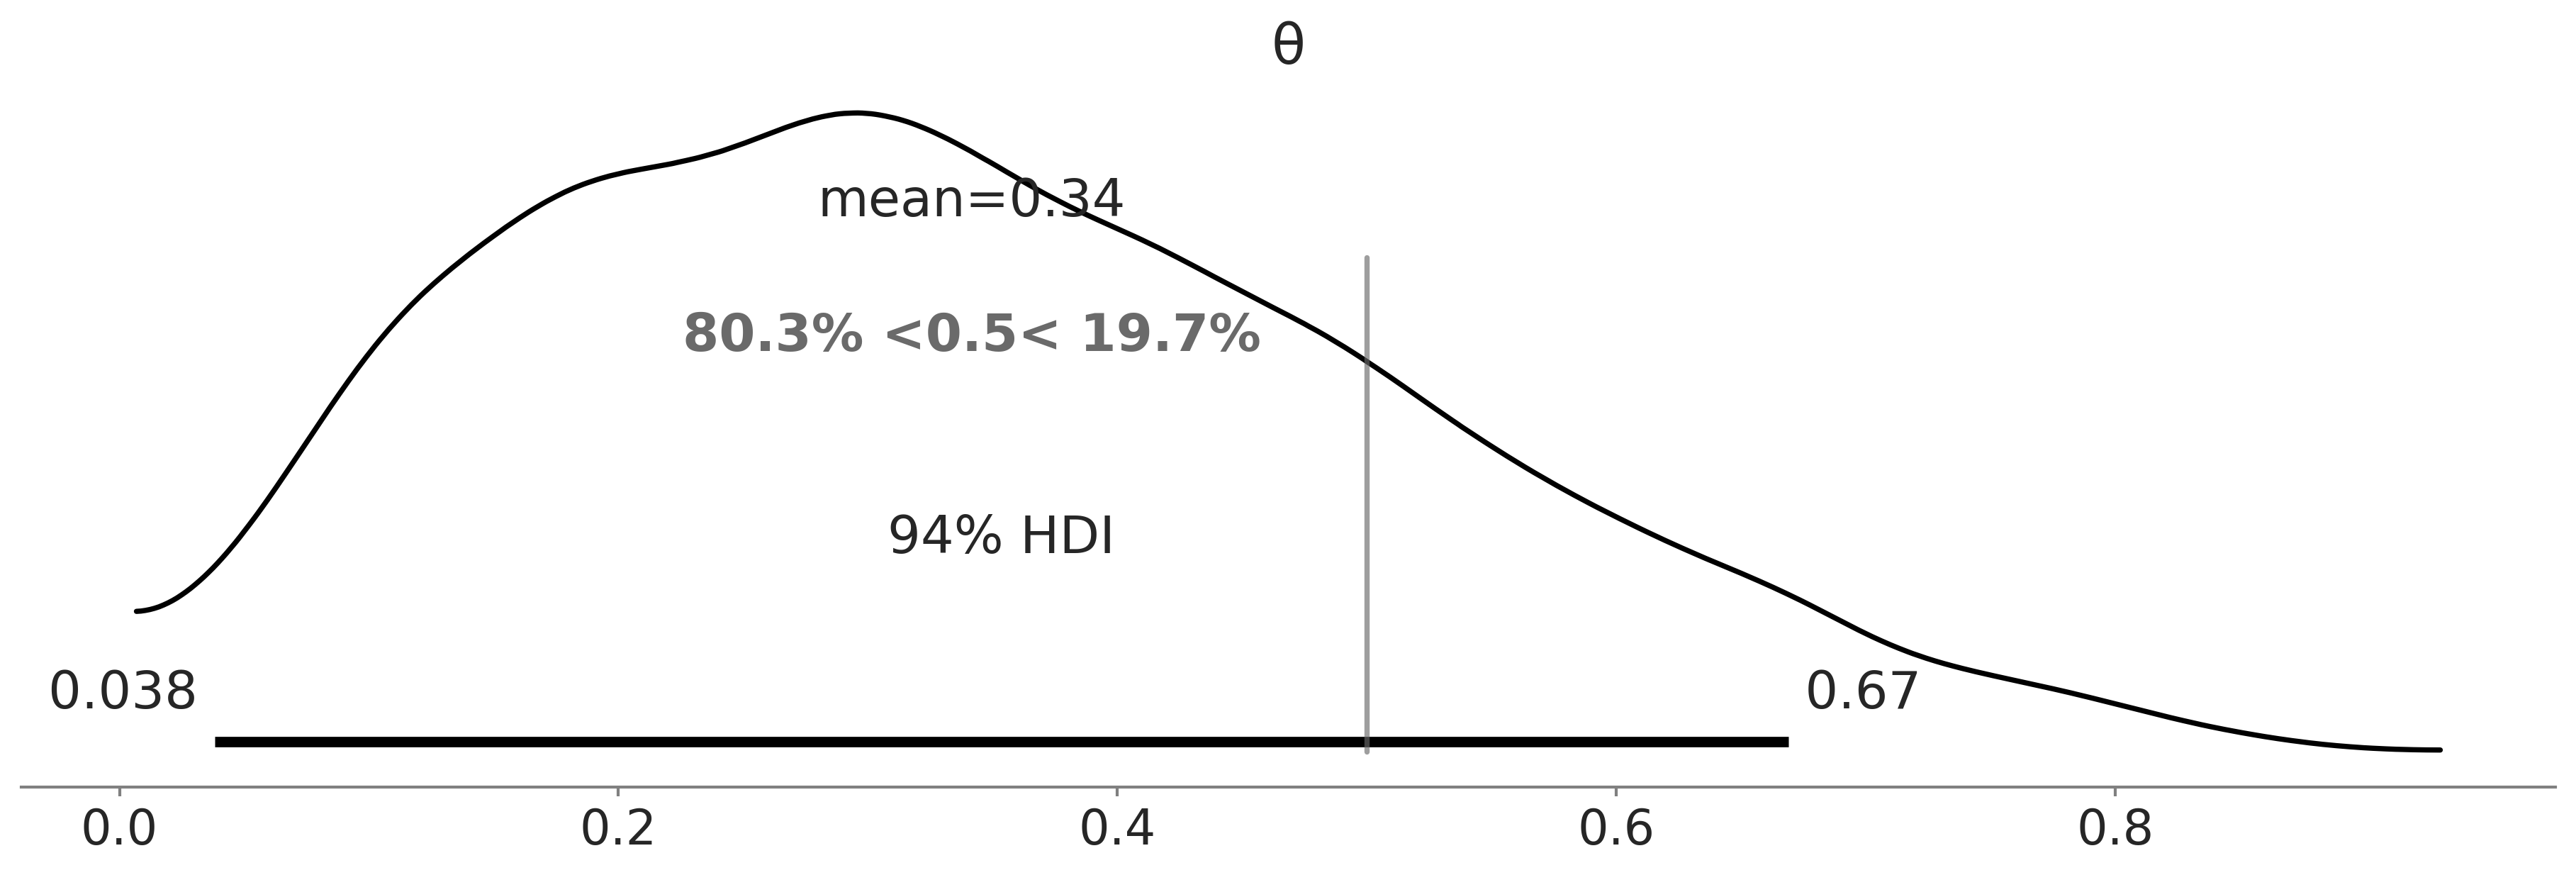

In [ ]:
az.plot_posterior(idata, ref_val=0.5, figsize=(12, 4))
# plt.savefig("../fig/idata_posterior_ref.png")

### Loss Functions

If you find the ROPE rules a bit clunky and want something more formal, loss functions are what you need! To make good decisions, it is important to achieve the highest possible precision for the estimated value of the relevant parameters and to consider the cost of making a mistake. The cost/benefit trade-off can be mathematically formalized using loss functions. These functions, or their inverses, are known by different names in various fields, such as cost functions, objective functions, fitness functions, and utility functions. Regardless of the name, the key idea is to use a function that measures the difference between the true value and the estimated value of a parameter. The larger the value of the loss function, the worse the estimation is (according to that loss function). Some common examples of loss functions are:

- The absolute loss function: \( |\theta - \hat{\theta}| \)
- The quadratic loss function: \( (\theta - \hat{\theta})^2 \)
- The 0-1 loss function: \( 1(\theta \ne \hat{\theta}) \), where \( 1 \) is the indicator function

In practice, we don’t know the true value of the parameter. Instead, we have an estimate in the form of a posterior distribution. Thus, we aim to find the value of \( \theta \) that minimizes the expected loss function, which is the loss function averaged over the entire posterior distribution.

In the following block of code, we have two loss functions: the absolute loss (`lossf_a`) and the quadratic loss (`lossf_b`). We will explore the value of \( \theta \) over a grid of 200 points. Then, we will plot those curves and include the value of \( \theta \) that minimizes each loss function. Here is the Python code without the plotting part:


In [ ]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]
np.argmin(lossf_a)

64

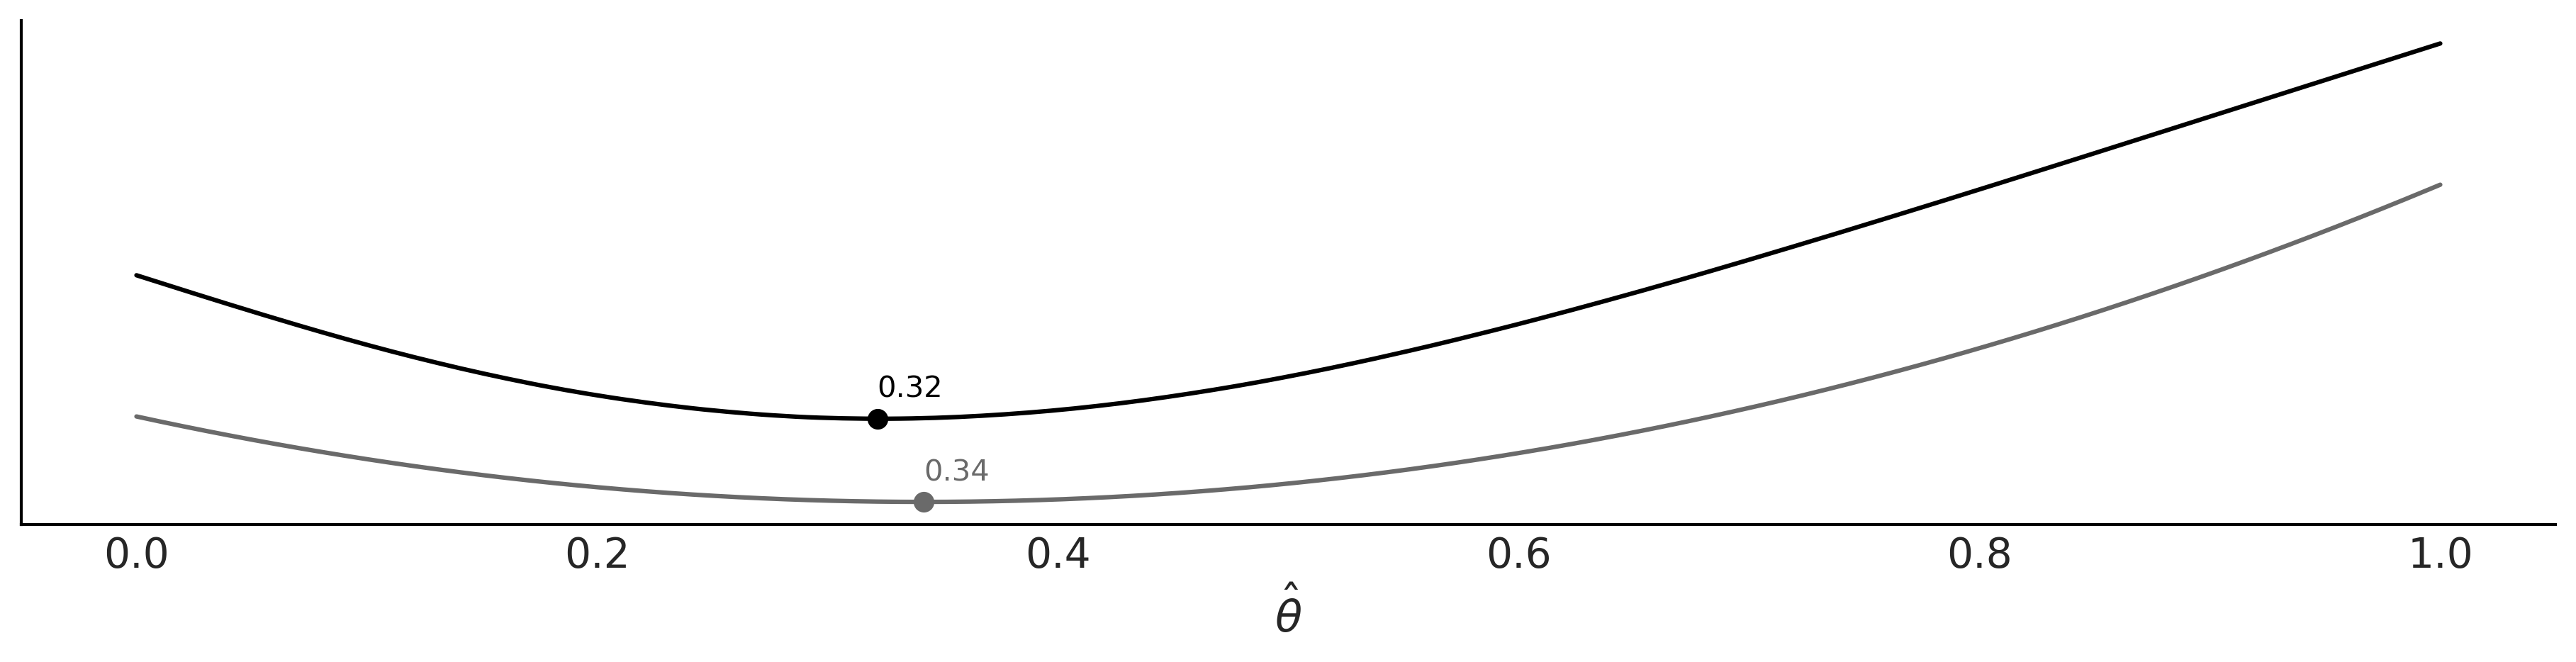

In [ ]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]
_, ax = plt.subplots(figsize=(12, 3))
for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    ax.plot(grid, lossf, c)
    ax.plot(grid[mini], lossf[mini], 'o', color=c)
    ax.annotate('{:.2f}'.format(grid[mini]),
    (grid[mini], lossf[mini] + 0.03), color=c)

    ax.set_yticks([])
    ax.set_xlabel(r'$\hat \theta$')

# plt.savefig("../fig/idata_loss.png")

What is more interesting in Figure is that the value we got from the absolute loss is equal to the median of the posterior, and the one we got from the quadratic loss is equal to the mean of the posterior. You can check this yourself by computing `np.mean(θ_pos)` and `np.median(θ_pos)`. This is no coincidence: different loss functions are related to different point estimates. The mean minimizes the quadratic loss, the median minimizes the absolute loss, and the mode minimizes the 0-1 loss.

If we want to be formal and compute a single-point estimate, we must decide which loss function to use. Conversely, if we choose a point estimate, we are implicitly (and maybe unconsciously) choosing a loss function. The advantage of explicitly choosing a loss function is that we can tailor it to our specific problem instead of relying on a predefined rule. It is common to see that the cost of making a decision is asymmetric. For example, vaccines can cause an overreaction of the immune system, but the benefits to both vaccinated and non-vaccinated people usually far outweigh the risks. Therefore, if our problem requires it, we can construct an asymmetric loss function.

Moreover, since the posterior is in the form of numerical samples, we can compute complex loss functions that aren’t restricted by mathematical convenience or simplicity. The following code, and the Figure below generated from it, is just a simple example of this:

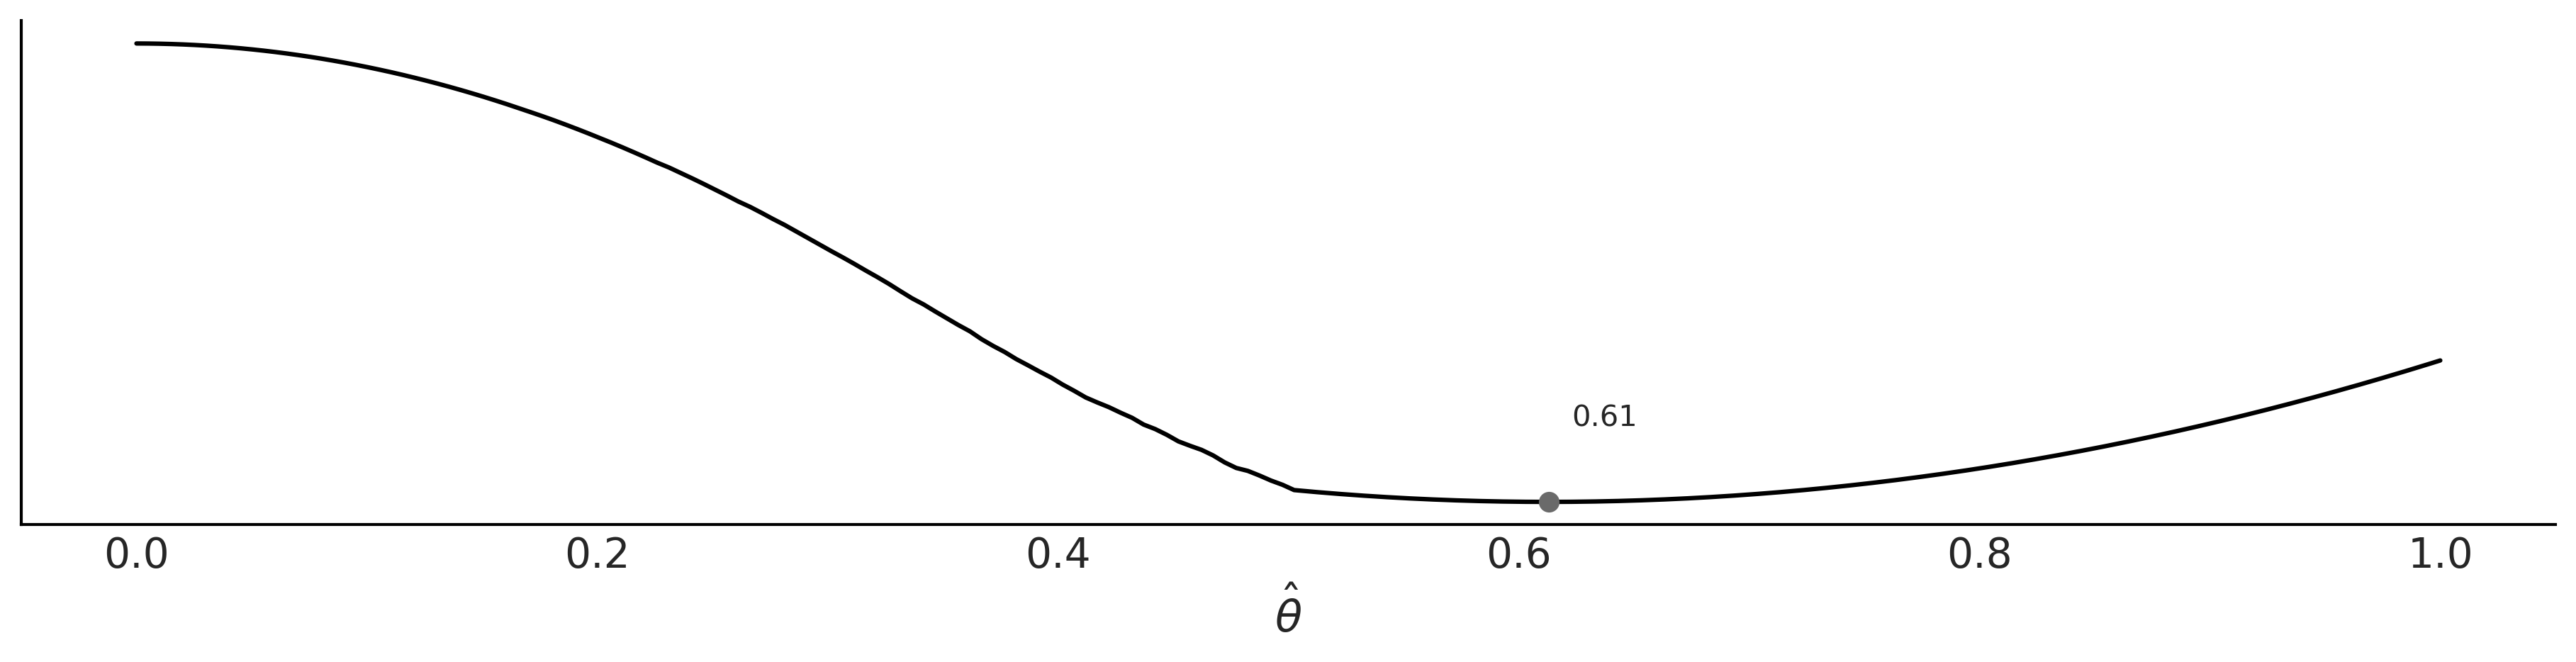

In [ ]:
lossf = []
for i in grid:
    if i < 0.5:
        f = 1/np.median(θ_pos / np.abs(i**2 - θ_pos))
    else:
        f = np.mean((i - θ_pos)**2 + np.exp(-i)) - 0.25
    lossf.append(f)
mini = np.argmin(lossf)
_, ax = plt.subplots(figsize=(12, 3))
ax.plot(grid, lossf)
ax.plot(grid[mini], lossf[mini], 'o')
ax.annotate('{:.2f}'.format(grid[mini]),
(grid[mini] + 0.01, lossf[mini] + 0.1))
ax.set_yticks([])
ax.set_xlabel(r'$\hat \theta$')
plt.savefig("../fig/idata_loss2.png")

 Up until now, we have been discussing the main notions of Bayesian statistics and probabilistic
 programming using the BetaBinomial model mainly because of its simplicity. In our path to build more
 complex models, we now shift our focus to delve into the realm of Gaussian inference. (Week 4)